In [1]:
# Tratamento de warning
import warnings
warnings.filterwarnings('ignore')

#### Análise dos dados sobre acidentes em rodovias em território nacional, disponibilizados pela Polícia Rodoviária Federal (PRF), com objetivo de:

>- auxiliar o cidadão na tomada de decisão de usar uma estrada (br) em determinado mês do ano, fase do dia (manha, tarde, noite), feriado ou não, uf, condição metereológica. Dessa forma, saber quais estradas e periodo do ano precisam de especial atenção para evitar acidentes fatais.

>-  nortear a decisão das autoridadess de onde investir em melhorias, recapeamento, postos policiais etc., com base na classificação, se estrada perigosa ou não (status).

Base de dados disponibilizada em https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-acidentes.

### Análise Exploratória do Dado

Além do pacote pandas, para lidar com data frames, o pacote holidays foi importado. Este pacote traz a informação das datas de feriados nacionais.

In [2]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import pandas as pd
import numpy as np
import holidays
pd.set_option('display.max_columns', None)
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
import plotly.express as px

In [2]:
cred = credentials.Certificate("./key/techfase3-firebase-adminsdk-fbsvc-e71cc04b8f.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [3]:
data_ref = db.collection("datatran")
results = data_ref .get()

RetryError: Timeout of 300.0s exceeded, last exception: 429 Quota exceeded.

In [4]:
data = [doc.to_dict() for doc in results]  
df = pd.DataFrame(data)

NameError: name 'results' is not defined

In [3]:
import glob

# Encontrar todos os arquivos CSV na pasta "dados"
arquivos = glob.glob('./dados/*.csv')

df = pd.concat([pd.read_csv(arquivo, encoding='latin1', delimiter=';') for arquivo in arquivos], ignore_index=True)

In [6]:
df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,496519.0,2023-01-01,domingo,02:00:00,ES,101,114,SOORETAMA,Ausência de reação do condutor,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Reta,Não,1,0,1,0,0,0,1,1,"-19,09484877","-40,05095848",SPRF-ES,DEL04-ES,UOP01-DEL04-ES
1,496543.0,2023-01-01,domingo,03:40:00,SP,116,"113,1",TAUBATE,Entrada inopinada do pedestre,Atropelamento de Pedestre,Com Vítimas Fatais,Plena Noite,Decrescente,Céu Claro,Dupla,Reta,Sim,5,1,0,0,0,4,0,2,"-23,0445658","-45,58259814",SPRF-SP,DEL02-SP,UOP02-DEL02-SP
2,496590.0,2023-01-01,domingo,01:40:00,MT,163,1112,GUARANTA DO NORTE,Reação tardia ou ineficiente do condutor,Tombamento,NaN,Plena Noite,Crescente,Ignorado,Simples,Curva;Declive,Não,2,0,0,1,0,2,1,3,"-9,70020602","-54,87588757",SPRF-MT,DEL06-MT,UOP03-DEL06-MT
3,496610.0,2023-01-01,domingo,10:40:00,PR,376,"314,8",ORTIGUEIRA,Velocidade Incompatível,Tombamento,Sem Vítimas,Pleno dia,Crescente,Sol,Dupla,Curva,Não,2,0,0,0,1,2,0,3,"-23,985512","-51,083555",SPRF-PR,DEL07-PR,UOP02-DEL07-PR
4,496659.0,2023-01-01,domingo,14:55:00,MG,116,"569,4",MANHUACU,Acumulo de água sobre o pavimento,Colisão frontal,Com Vítimas Feridas,Pleno dia,Decrescente,Chuva,Simples,Declive;Curva,Não,4,0,0,2,1,1,2,3,"-20,10007457","-42,17884091",SPRF-MG,DEL06-MG,UOP03-DEL06-MG


In [4]:
df['data_inversa'] = df['data_inversa'].str.strip()
df['data_inversa'] = pd.to_datetime(df['data_inversa'], format='%Y-%m-%d', errors='coerce')
df['ano'] = pd.to_datetime(df['data_inversa'], errors='coerce').dt.year
df['mes'] = pd.to_datetime(df['data_inversa'], errors='coerce').dt.month

In [5]:
#df['ano'] = pd.to_numeric(df['ano'], errors='coerce').astype('Int64')
df['mortos'] = pd.to_numeric(df['mortos'], errors='coerce').astype('Int64')
df['feridos_graves'] = pd.to_numeric(df['feridos_graves'], errors='coerce').astype('Int64')
df['veiculos'] = pd.to_numeric(df['veiculos'], errors='coerce').astype('Int64')

In [9]:
df.head(3)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,ano,mes
0,496519.0,2023-01-01,domingo,02:00:00,ES,101,114,SOORETAMA,Ausência de reação do condutor,Saída de leito carroçável,Com Vítimas Feridas,Plena Noite,Crescente,Céu Claro,Simples,Reta,Não,1,0,1,0,0,0,1,1,"-19,09484877","-40,05095848",SPRF-ES,DEL04-ES,UOP01-DEL04-ES,2023,1
1,496543.0,2023-01-01,domingo,03:40:00,SP,116,"113,1",TAUBATE,Entrada inopinada do pedestre,Atropelamento de Pedestre,Com Vítimas Fatais,Plena Noite,Decrescente,Céu Claro,Dupla,Reta,Sim,5,1,0,0,0,4,0,2,"-23,0445658","-45,58259814",SPRF-SP,DEL02-SP,UOP02-DEL02-SP,2023,1
2,496590.0,2023-01-01,domingo,01:40:00,MT,163,1112,GUARANTA DO NORTE,Reação tardia ou ineficiente do condutor,Tombamento,NaN,Plena Noite,Crescente,Ignorado,Simples,Curva;Declive,Não,2,0,0,1,0,2,1,3,"-9,70020602","-54,87588757",SPRF-MT,DEL06-MT,UOP03-DEL06-MT,2023,1


In [10]:
df.shape

(163421, 32)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163421 entries, 0 to 163420
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      163421 non-null  float64       
 1   data_inversa            163421 non-null  datetime64[ns]
 2   dia_semana              163421 non-null  object        
 3   horario                 163421 non-null  object        
 4   uf                      163421 non-null  object        
 5   br                      163421 non-null  int64         
 6   km                      163421 non-null  object        
 7   municipio               163421 non-null  object        
 8   causa_acidente          163421 non-null  object        
 9   tipo_acidente           163421 non-null  object        
 10  classificacao_acidente  163418 non-null  object        
 11  fase_dia                163421 non-null  object        
 12  sentido_via             163421

### Fazendo primeira inspeção para seleção de atributos com base no problema a ser resolvido

In [9]:
df.describe(include='all')

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,ano,mes
count,163421.000000,163421,163421,163421,163421,163421.000000,163421,163421,163421,163421,163418,163421,163421,163421,163421,163421,163421,163421.000000,163421.000000,163421.000000,163421.000000,163421.000000,163421.000000,163421.000000,163421.000000,163421,163421,163401,163348,163253,163421.000000,163421.000000
unique,NaN,851,7,1437,27,NaN,8882,1947,75,17,3,4,3,10,3,943,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90224,90183,28,153,402,NaN,NaN
top,NaN,2024-12-21 00:00:00,domingo,19:00:00,MG,NaN,1,BRASILIA,Reação tardia ou ineficiente do condutor,Colisão traseira,Com Vítimas Feridas,Pleno dia,Crescente,Céu Claro,Simples,Reta,Não,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"-27,59193546","-48,61824557",SPRF-MG,DEL01-PR,UOP01-DEL01-SC,NaN,NaN
freq,NaN,319,26557,2405,21198,NaN,788,2349,24113,31352,125628,90602,88034,103340,79392,90869,93879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,83,21144,5815,2689,NaN,NaN
first,NaN,2023-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2025-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,588093.820482,NaN,NaN,NaN,NaN,209.247765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.607033,0.083013,0.880334,0.277828,1.056810,0.396363,1.158162,1.990901,NaN,NaN,NaN,NaN,NaN,2023.723004,6.094296
std,52436.538404,NaN,NaN,NaN,NaN,129.104793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.256839,0.350148,1.108036,0.623514,1.783902,0.848289,1.228514,1.140464,NaN,NaN,NaN,NaN,NaN,0.689654,3.519355
min,496506.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,2023.000000,1.000000
25%,542921.000000,NaN,NaN,NaN,NaN,101.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,2023.000000,3.000000


In [10]:
#Verificação de dados nulos
df.isnull().sum()

id                          0
data_inversa                0
dia_semana                  0
horario                     0
uf                          0
br                          0
km                          0
municipio                   0
causa_acidente              0
tipo_acidente               0
classificacao_acidente      3
fase_dia                    0
sentido_via                 0
condicao_metereologica      0
tipo_pista                  0
tracado_via                 0
uso_solo                    0
pessoas                     0
mortos                      0
feridos_leves               0
feridos_graves              0
ilesos                      0
ignorados                   0
feridos                     0
veiculos                    0
latitude                    0
longitude                   0
regional                   20
delegacia                  73
uop                       168
ano                         0
mes                         0
dtype: int64

In [6]:
datatran = df[['id', 'ano', 'mes', 'data_inversa', 'uf', 'br', 'km', 'municipio', 'causa_acidente', 'classificacao_acidente', 'veiculos', 'condicao_metereologica', 'fase_dia', 'dia_semana', 'tipo_acidente', 'tipo_pista', 'mortos', 'feridos_graves', 'latitude', 'longitude']]

In [13]:
datatran.head(3)

,id,ano,mes,data_inversa,uf,br,km,municipio,causa_acidente,classificacao_acidente,veiculos,condicao_metereologica,fase_dia,dia_semana,tipo_acidente,tipo_pista,mortos,feridos_graves,latitude,longitude
0,496519.0,2023,1,2023-01-01,ES,101,114,SOORETAMA,Ausência de reação do condutor,Com Vítimas Feridas,1,Céu Claro,Plena Noite,domingo,Saída de leito carroçável,Simples,0,0,"-19,09484877","-40,05095848"
1,496543.0,2023,1,2023-01-01,SP,116,"113,1",TAUBATE,Entrada inopinada do pedestre,Com Vítimas Fatais,2,Céu Claro,Plena Noite,domingo,Atropelamento de Pedestre,Dupla,1,0,"-23,0445658","-45,58259814"
2,496590.0,2023,1,2023-01-01,MT,163,1112,GUARANTA DO NORTE,Reação tardia ou ineficiente do condutor,NaN,3,Ignorado,Plena Noite,domingo,Tombamento,Simples,0,1,"-9,70020602","-54,87588757"


### Tratando valores ausentes:

In [14]:
selection = datatran[datatran['classificacao_acidente'].isnull()]
selection

,id,ano,mes,data_inversa,uf,br,km,municipio,causa_acidente,classificacao_acidente,veiculos,condicao_metereologica,fase_dia,dia_semana,tipo_acidente,tipo_pista,mortos,feridos_graves,latitude,longitude
2,496590.0,2023,1,2023-01-01,MT,163,1112,GUARANTA DO NORTE,Reação tardia ou ineficiente do condutor,NaN,3,Ignorado,Plena Noite,domingo,Tombamento,Simples,0,1,"-9,70020602","-54,87588757"
67766,571789.0,2024,1,2024-01-01,ES,101,38,CONCEICAO DA BARRA,Ultrapassagem Indevida,NaN,3,Céu Claro,Plena Noite,segunda-feira,Colisão lateral sentido oposto,Simples,0,1,-18.48261,-39.92379
146695,652555.0,2025,1,2025-01-01,RS,290,"27,1",SANTO ANTONIO DA PATRULHA,Demais falhas mecânicas ou elétricas,NaN,2,Céu Claro,Pleno dia,quarta-feira,Saída de leito carroçável,Dupla,0,0,"-29,880135","-50,514297"


In [15]:
datatran['classificacao_acidente'].unique()

array(['Com Vítimas Feridas', 'Com Vítimas Fatais', nan, 'Sem Vítimas'],
      dtype=object)

In [7]:
datatran.loc[
    (datatran['classificacao_acidente'].isnull()) & (datatran['mortos'] == 0) & (datatran['feridos_graves'] == 1),
    'classificacao_acidente'
] = "Com Vítimas Feridas"

datatran.loc[
    (datatran['classificacao_acidente'].isnull()) & (datatran['mortos'] == 0) & (datatran['feridos_graves'] == 0),
    'classificacao_acidente'
] = "Sem Vítimas"

In [17]:
datatran['classificacao_acidente'].unique()

array(['Com Vítimas Feridas', 'Com Vítimas Fatais', 'Sem Vítimas'],
      dtype=object)

### Tratando valores ausentes:
>- dropna somente nas colunas que são essenciais para o modelo

In [8]:
#Remoção dos dados nulos
datatran.dropna(subset=['br','km', 'data_inversa', 'id' ], inplace=True)

In [19]:
datatran.isnull().sum()

id                        0
ano                       0
mes                       0
data_inversa              0
uf                        0
br                        0
km                        0
municipio                 0
causa_acidente            0
classificacao_acidente    0
veiculos                  0
condicao_metereologica    0
fase_dia                  0
dia_semana                0
tipo_acidente             0
tipo_pista                0
mortos                    0
feridos_graves            0
latitude                  0
longitude                 0
dtype: int64

In [20]:
datatran['uf'].unique()

array(['ES', 'SP', 'MT', 'PR', 'MG', 'BA', 'RJ', 'RS', 'SC', 'PI', 'GO',
       'PE', 'MS', 'MA', 'CE', 'AP', 'PB', 'SE', 'RO', 'PA', 'RN', 'TO',
       'RR', 'DF', 'AL', 'AC', 'AM'], dtype=object)

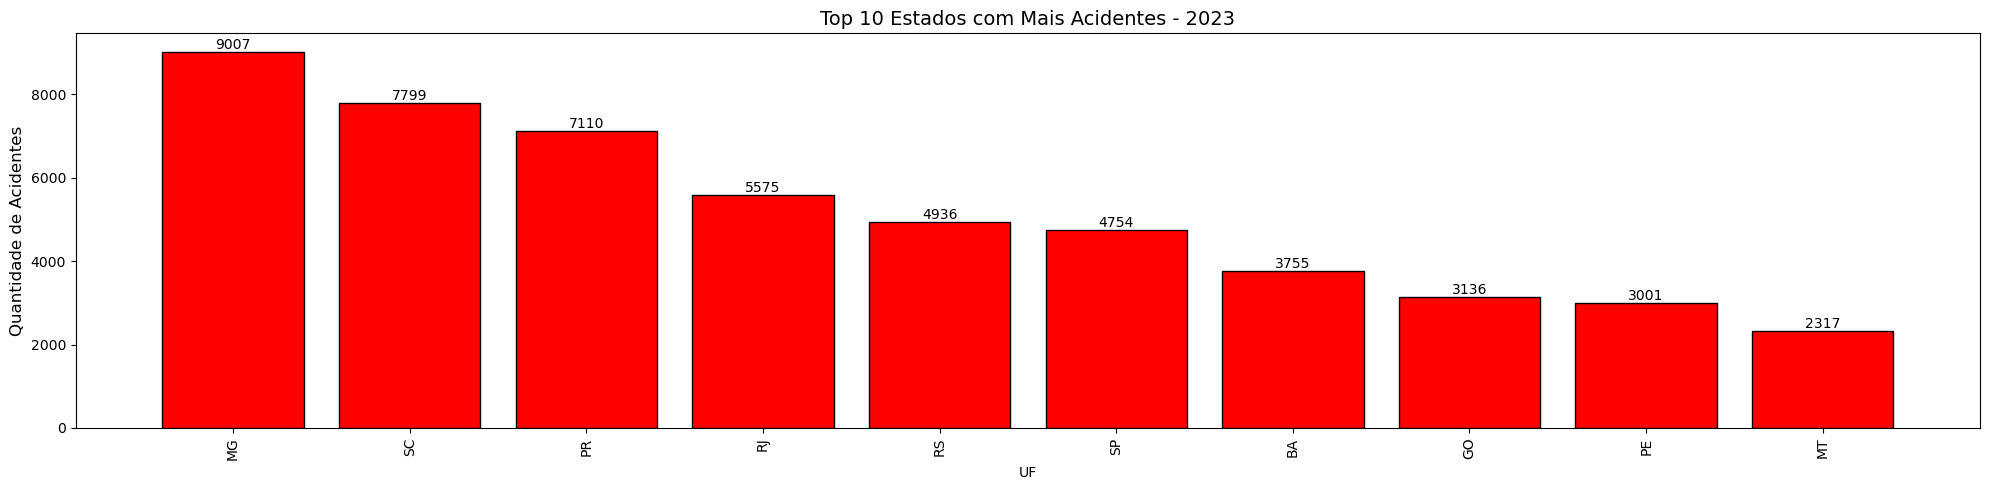

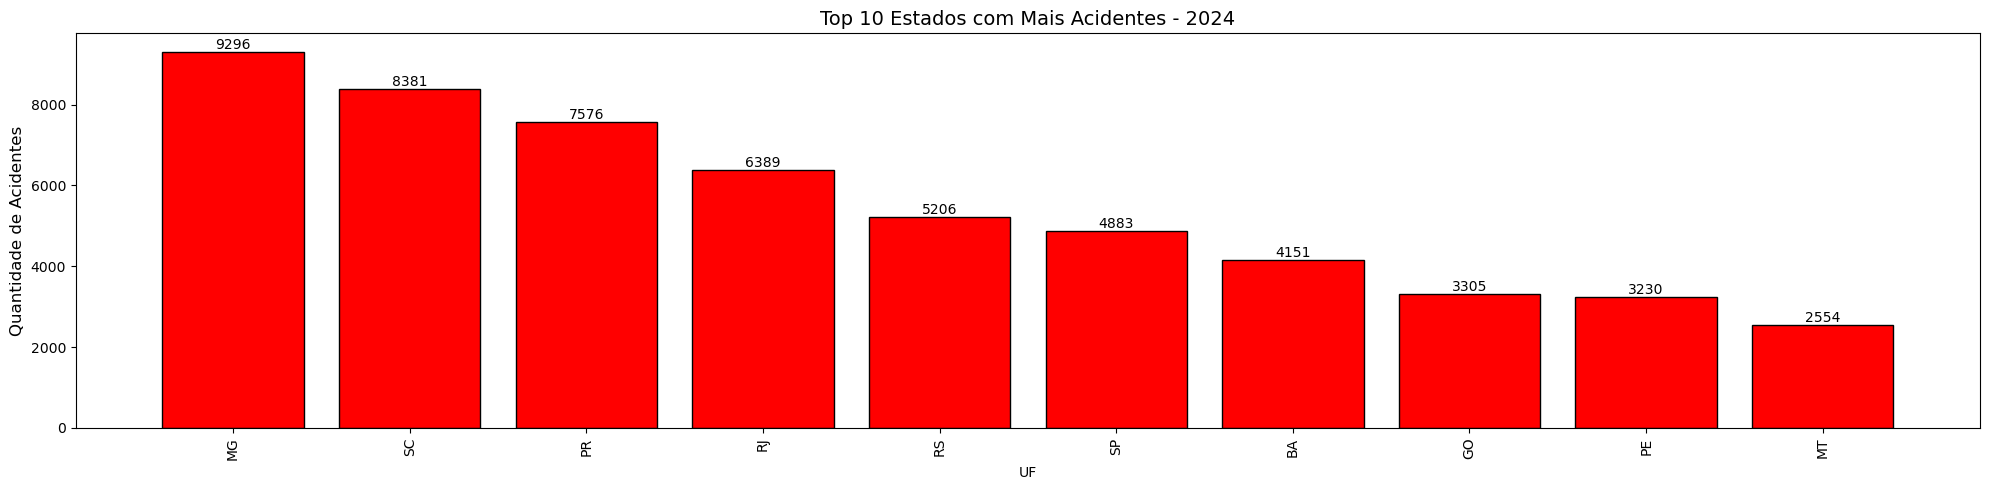

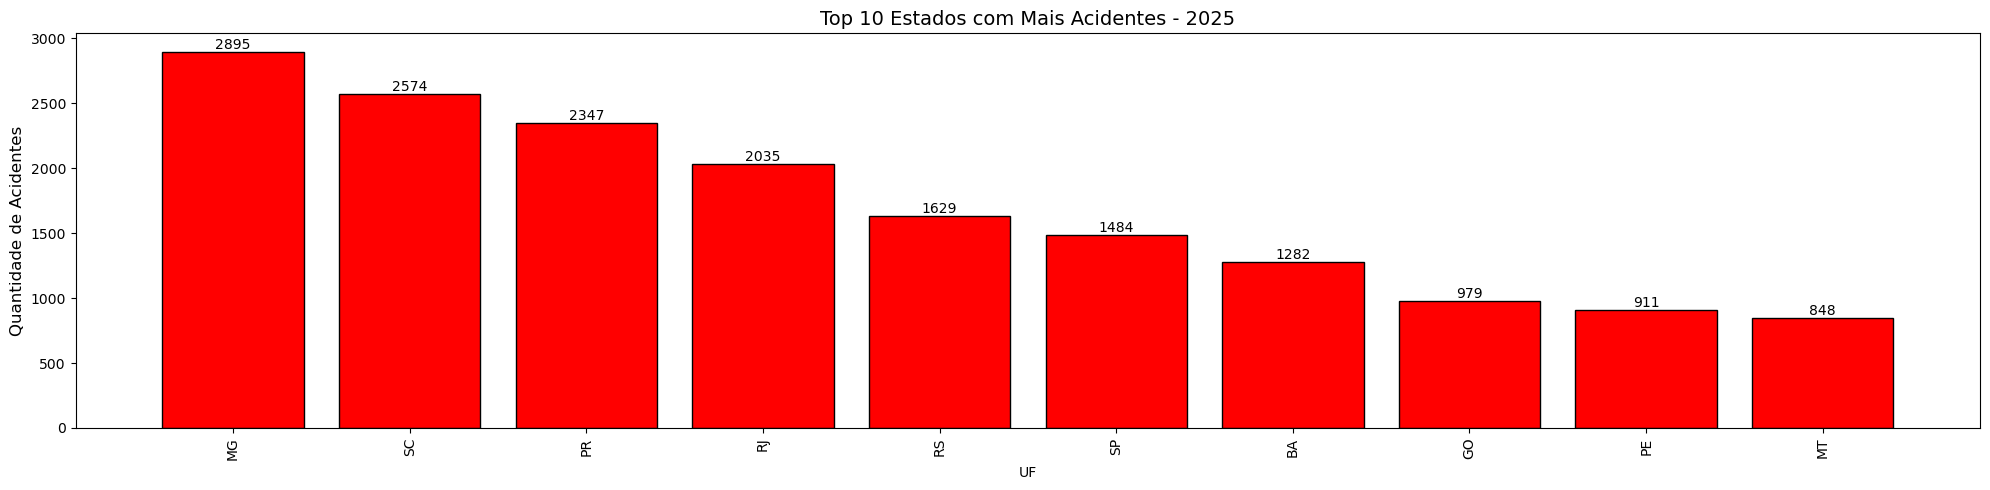

In [21]:
df_top = df.groupby(['ano', 'uf']).size().reset_index(name='QuantidadeAcidentesUF')

anos = df_top['ano'].unique()

for ano in anos:
    df_ano = df_top[df_top['ano'] == ano].sort_values(by='QuantidadeAcidentesUF', ascending=False).head(10)  # Top 10 UFs
    
    plt.figure(figsize=(20, 5))
    plt.bar(df_ano['uf'], df_ano['QuantidadeAcidentesUF'], color='red', edgecolor='black')
    plt.title(f'Top 10 Estados com Mais Acidentes - {ano}', fontsize=14)
    plt.xlabel('UF', fontsize=10)
    plt.ylabel('Quantidade de Acidentes', fontsize=12)
    
    # Adicionar valores sobre as barras
    for i, valor in enumerate(df_ano['QuantidadeAcidentesUF']):
        plt.text(i, valor + 0.1, str(valor), ha='center', va='bottom', fontsize=10, color='black')
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Inspecionando o atributo "classificação_acidente":

In [22]:
datatran['classificacao_acidente'].unique()

array(['Com Vítimas Feridas', 'Com Vítimas Fatais', 'Sem Vítimas'],
      dtype=object)

### Identificando Rodovia perigosa ou não com base nos mortos e	feridos_graves	

In [9]:
datatran['status'] = np.where((df['mortos'] > 0) | (df['feridos_graves'] > 0), 'Perigosa', 'Segura')


In [24]:
datatran['status'].value_counts()

Segura      117414
Perigosa     46007
Name: status, dtype: int64

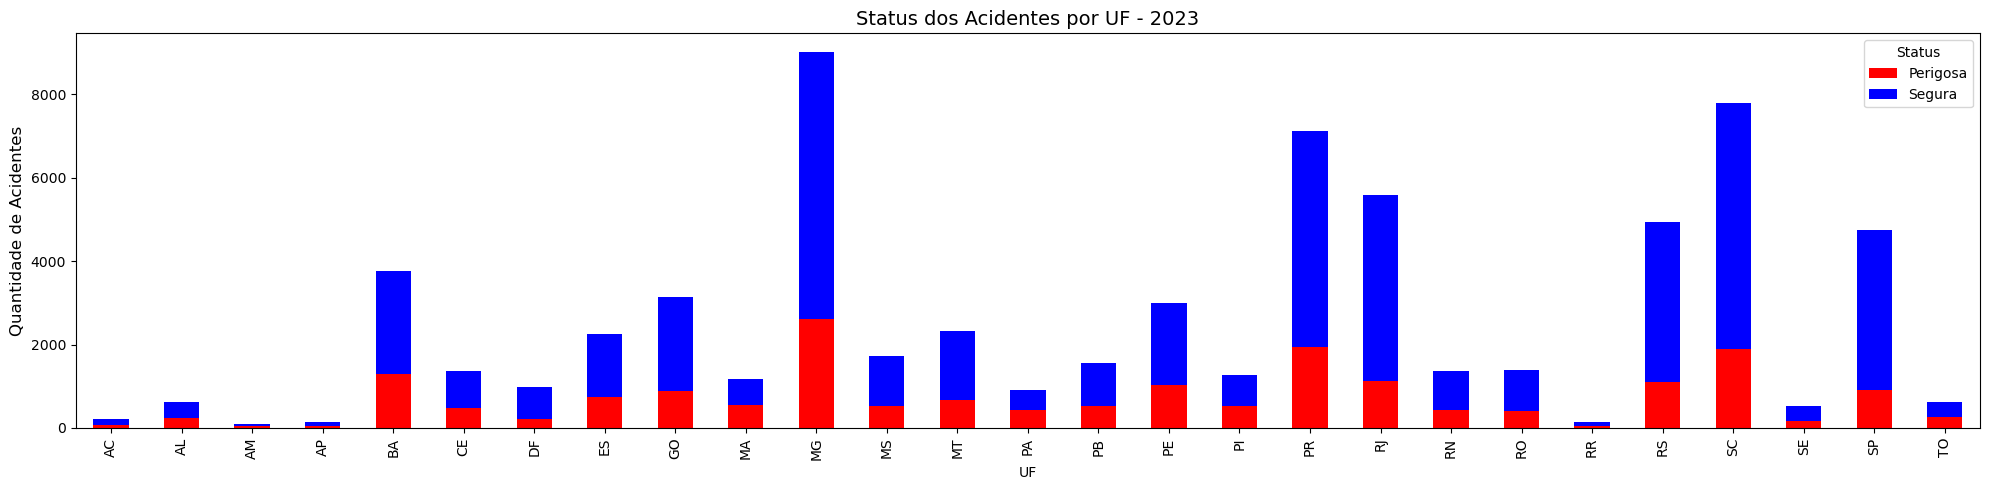

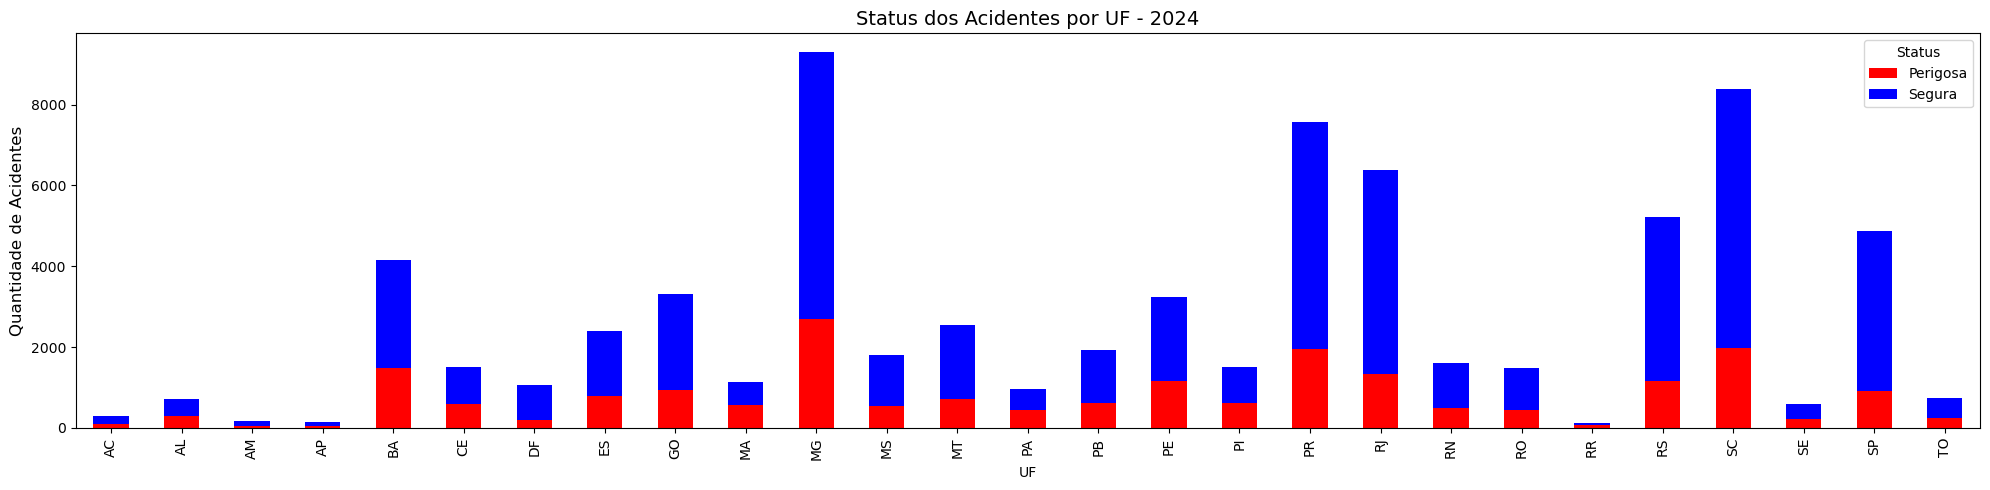

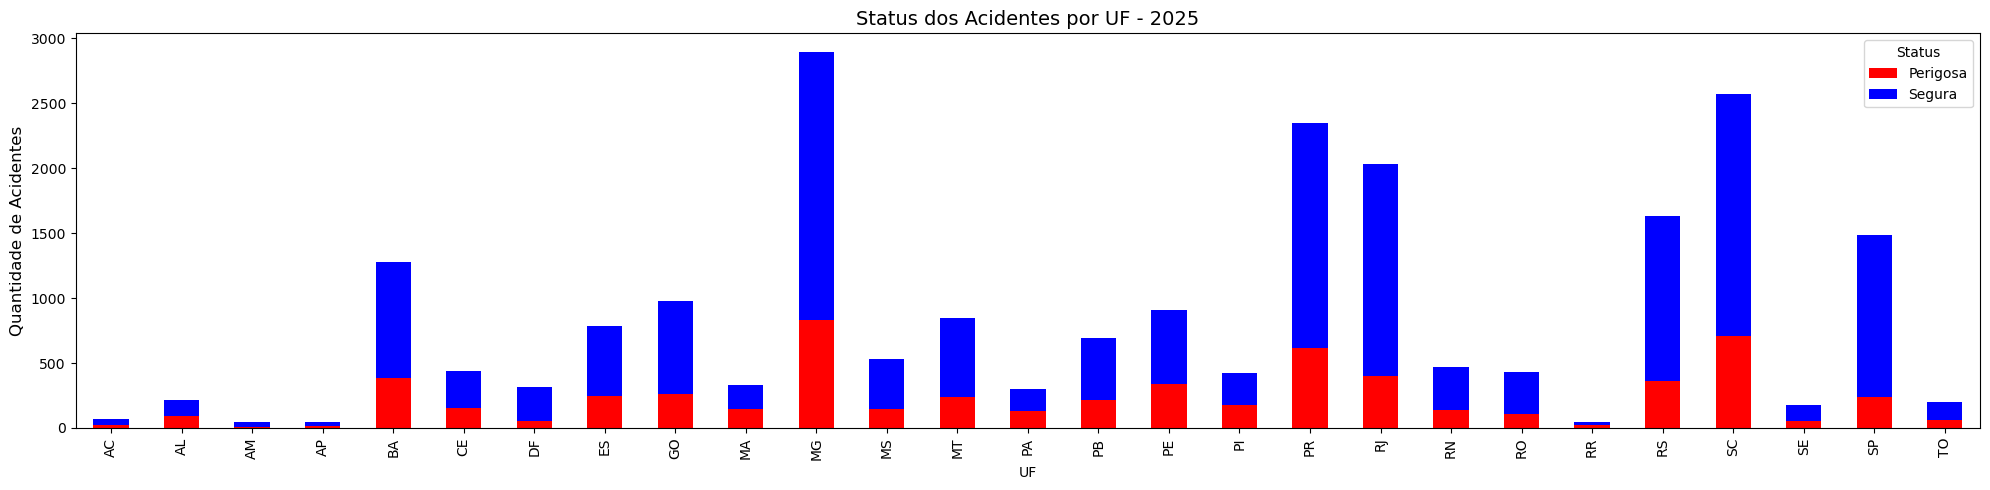

In [25]:
# Contar quantidade de acidentes por status, ano e UF
df_top = datatran.groupby(['ano', 'uf', 'status']).size().reset_index(name='StatusAcidentes')

# Criar gráficos para cada ano
anos = df_top['ano'].unique()

for ano in anos:
    df_ano = df_top[df_top['ano'] == ano]
    
    # Reestruturar os dados para garantir que todas as categorias sejam exibidas corretamente
    df_pivot = df_ano.pivot(index='uf', columns='status', values='StatusAcidentes').fillna(0)

    # Criar gráfico de barras empilhadas
    df_pivot.plot(kind='bar', stacked=True, figsize=(20, 5), color={'Perigosa': 'red', 'Segura': 'blue'})
    
    plt.title(f'Status dos Acidentes por UF - {ano}', fontsize=14)
    plt.xlabel('UF', fontsize=10)
    plt.ylabel('Quantidade de Acidentes', fontsize=12)
    plt.legend(title="Status")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Inspeção do dado

In [26]:
datatran['dia_semana'].unique()

array(['domingo', 'segunda-feira', 'terça-feira', 'quarta-feira',
       'quinta-feira', 'sexta-feira', 'sábado'], dtype=object)

In [27]:
datatran['municipio'].unique()

array(['SOORETAMA', 'TAUBATE', 'GUARANTA DO NORTE', ...,
       'SANTO AMARO DO MARANHAO', 'BARRA DOS COQUEIROS', 'BONITO'],
      dtype=object)

In [28]:
datatran['fase_dia'].unique()

array(['Plena Noite', 'Pleno dia', 'Anoitecer', 'Amanhecer'], dtype=object)

In [29]:
datatran['causa_acidente'].unique()

array(['Ausência de reação do condutor', 'Entrada inopinada do pedestre',
       'Reação tardia ou ineficiente do condutor',
       'Velocidade Incompatível', 'Acumulo de água sobre o pavimento',
       'Condutor Dormindo', 'Desrespeitar a preferência no cruzamento',
       'Demais falhas mecânicas ou elétricas', 'Transitar na contramão',
       'Acessar a via sem observar a presença dos outros veículos',
       'Manobra de mudança de faixa',
       'Avarias e/ou desgaste excessivo no pneu', 'Pista Escorregadia',
       'Condutor deixou de manter distância do veículo da frente',
       'Trafegar com motocicleta (ou similar) entre as faixas',
       'Pista esburacada', 'Pedestre andava na pista',
       'Acumulo de óleo sobre o pavimento',
       'Carga excessiva e/ou mal acondicionada',
       'Condutor desrespeitou a iluminação vermelha do semáforo', 'Chuva',
       'Mal súbito do condutor', 'Curva acentuada', 'Obstrução na via',
       'Ultrapassagem Indevida', 'Afundamento ou ondula

In [30]:
datatran['condicao_metereologica'].unique()

array(['Céu Claro', 'Ignorado', 'Sol', 'Chuva', 'Nublado',
       'Garoa/Chuvisco', 'Nevoeiro/Neblina', 'Vento', 'Granizo', 'Neve'],
      dtype=object)

In [31]:
aux = datatran.query("condicao_metereologica == 'Céu Claro'")
aux['fase_dia'].unique()

array(['Plena Noite', 'Pleno dia', 'Anoitecer', 'Amanhecer'], dtype=object)

### Tratanto "condicao_metereologica" = "Ignorado"
>- assumindo que não foi importante registrar a condição metereológica, atribuiremos "Céu Claro" ( no contexto real, certificar com o dono do dado qual o tratamento adequado)

In [10]:
datatran['condicao_metereologica'].replace('Ignorado', 'Céu Claro', inplace=True)
datatran['condicao_metereologica'].unique()

array(['Céu Claro', 'Sol', 'Chuva', 'Nublado', 'Garoa/Chuvisco',
       'Nevoeiro/Neblina', 'Vento', 'Granizo', 'Neve'], dtype=object)

In [33]:
datatran['tipo_pista'].unique()

array(['Simples', 'Dupla', 'Múltipla'], dtype=object)

#### Analisando se data era ou não um feriado nacional pois isso pode ser um fator determinante para aumento de fluxo de veiculos e acidentes.


In [11]:
datatran.insert(2, 'feriado', '')
feriado = []
for i in holidays.Brazil()['2022-01-01':'2025-12-31']:
    feriado.append(i)
datatran['feriado'] = datatran['data_inversa'].isin(feriado)
datatran['feriado'].replace(True, 'y', inplace=True)
datatran['feriado'].replace(False, 'n', inplace=True)
datatran['feriado'].unique()

array(['y', 'n'], dtype=object)

In [35]:
datatran.head()

,id,ano,feriado,mes,data_inversa,uf,br,km,municipio,causa_acidente,classificacao_acidente,veiculos,condicao_metereologica,fase_dia,dia_semana,tipo_acidente,tipo_pista,mortos,feridos_graves,latitude,longitude,status
0,496519.0,2023,y,1,2023-01-01,ES,101,114,SOORETAMA,Ausência de reação do condutor,Com Vítimas Feridas,1,Céu Claro,Plena Noite,domingo,Saída de leito carroçável,Simples,0,0,"-19,09484877","-40,05095848",Segura
1,496543.0,2023,y,1,2023-01-01,SP,116,"113,1",TAUBATE,Entrada inopinada do pedestre,Com Vítimas Fatais,2,Céu Claro,Plena Noite,domingo,Atropelamento de Pedestre,Dupla,1,0,"-23,0445658","-45,58259814",Perigosa
2,496590.0,2023,y,1,2023-01-01,MT,163,1112,GUARANTA DO NORTE,Reação tardia ou ineficiente do condutor,Com Vítimas Feridas,3,Céu Claro,Plena Noite,domingo,Tombamento,Simples,0,1,"-9,70020602","-54,87588757",Perigosa
3,496610.0,2023,y,1,2023-01-01,PR,376,"314,8",ORTIGUEIRA,Velocidade Incompatível,Sem Vítimas,3,Sol,Pleno dia,domingo,Tombamento,Dupla,0,0,"-23,985512","-51,083555",Segura
4,496659.0,2023,y,1,2023-01-01,MG,116,"569,4",MANHUACU,Acumulo de água sobre o pavimento,Com Vítimas Feridas,3,Chuva,Pleno dia,domingo,Colisão frontal,Simples,0,2,"-20,10007457","-42,17884091",Perigosa


### SALVANDO DF COMO VARIÁVEL GLOBAL PARA CONTINUAR O PROJETO NO OUTRO NOTEBOOK:

>- 2 Machine Learning.ipynb
>- 3 LDA para topic model.ipynb

In [12]:
%store datatran

Stored 'datatran' (DataFrame)


In [ ]:
datatran.to_csv('./resultados/datatran.csv', index=False, sep=';')